# Lab Vision Sytems: Session 2

# Today:

### 1: Solution Assignment 1
### 2: Learning and Optimization
### 3: Convolutional Neural Networks (CNN)

### Why computing the gradient norm?

<img src="imgs/GradTBoard.png" style="width:62%"><img src="imgs/GradientInspector.png" style="width:38%">

# 1: Solution Assignment 1

By Gjergj Plepi & Jan Niklas Ewertz

# 2: Learning and Optimization

# 3: Convolutional Networks (CNNs)

In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

plt.style.use('seaborn')

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

## Data

In [3]:
# Downloading and Loading Dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
 
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [4]:
# Fitting data loaders for iterating
B_SIZE = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE, 
                                          shuffle=False)

In [5]:
iterator = iter(test_loader)

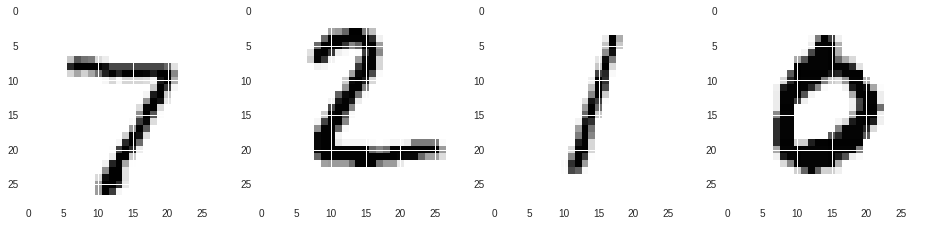

In [6]:
b = next(iterator)
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(16, 4)
for i in range(4):
    ax[i].imshow(b[0][i, 0])

## Model

In [7]:
class CNN(nn.Module):
    """ 
    Varation of LeNet: a simple CNN model
    for handwritten digit recognition
    """
    def __init__(self):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        # (1,28,28)
        conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        # (16, 24, 24)
        relu1 = nn.ReLU()
        maxpool1 = nn.MaxPool2d(kernel_size=2)
        # (16, 12, 12)
        self.layer1 = nn.Sequential(
                conv1, relu1, maxpool1
            )
      
        # layer 2
        # (16, 12, 12)
        conv2 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=5, stride=1, padding=0)
        # (32, 8, 8)
        relu2 = nn.ReLU()
        maxpool2 = nn.MaxPool2d(kernel_size=2)
        # (32, 4, 4)
        self.layer2 = nn.Sequential(
                conv2, relu2, maxpool2
            )
        
        # fully connected classifier
        in_dim = 32 * 4 * 4
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
        return
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        out1 = self.layer1(x)
        out2 = self.layer2(out1) # (B, 32, 4 ,4 ) -> (B, 32 * 4 * 4)
        out2_flat = out2.view(cur_b_size, -1)
        y = self.fc(out2_flat)
        return y
    
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [9]:
cnn

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [11]:
cnn = CNN()
params = count_model_params(cnn)
print(f"Model has {params} learnable parameters")

Model has 18378 learnable parameters


## Training

In [13]:
LR = 3e-4
EPOCHS = 10
EVAL_FREQ = 1
SAVE_FREQ = 10

In [14]:
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}
init_epoch = 0

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = cnn.to(device)

In [17]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [18]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss


def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [24]:
# loading model 
savepath = os.path.join(os.getcwd(), "models", "checkpoint_epoch_40.pth")
model, optimizer, init_epoch, stats = load_model(cnn, optimizer, savepath)

In [20]:
loss_hist = []

for epoch in range(init_epoch, EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = cnn(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])
    
    # evaluating model
    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)  
        print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:   
        accuracy, valid_loss = -1, -1
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)
    
    # saving checkpoint
    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

Epoch 1 Iter 938: loss 0.13801. : 100%|██████████| 938/938 [00:06<00:00, 150.92it/s]


Accuracy at epoch 0: 94.8%


Epoch 2 Iter 938: loss 0.08097. : 100%|██████████| 938/938 [00:06<00:00, 148.26it/s]


Accuracy at epoch 1: 97.34%


Epoch 3 Iter 938: loss 0.05827. : 100%|██████████| 938/938 [00:06<00:00, 147.64it/s]


Accuracy at epoch 2: 97.92%


Epoch 4 Iter 938: loss 0.02957. : 100%|██████████| 938/938 [00:06<00:00, 147.55it/s]


Accuracy at epoch 3: 98.32%


Epoch 5 Iter 938: loss 0.02047. : 100%|██████████| 938/938 [00:06<00:00, 145.75it/s]


Accuracy at epoch 4: 98.35%


Epoch 6 Iter 938: loss 0.09686. : 100%|██████████| 938/938 [00:06<00:00, 147.48it/s]


Accuracy at epoch 5: 98.53%


Epoch 7 Iter 938: loss 0.01189. : 100%|██████████| 938/938 [00:06<00:00, 147.38it/s]


Accuracy at epoch 6: 98.55%


Epoch 8 Iter 938: loss 0.00221. : 100%|██████████| 938/938 [00:06<00:00, 146.36it/s]


Accuracy at epoch 7: 98.76%


Epoch 9 Iter 938: loss 0.00059. : 100%|██████████| 938/938 [00:06<00:00, 147.47it/s]


Accuracy at epoch 8: 98.75%


Epoch 10 Iter 938: loss 0.07839. : 100%|██████████| 938/938 [00:06<00:00, 146.36it/s]


Accuracy at epoch 9: 98.8%


In [25]:
accuracy, _ = eval_model(cnn)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 98.93%


In [26]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])

eval_loss = np.array(stats["valid_loss"])
accuracy = np.array(stats["accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

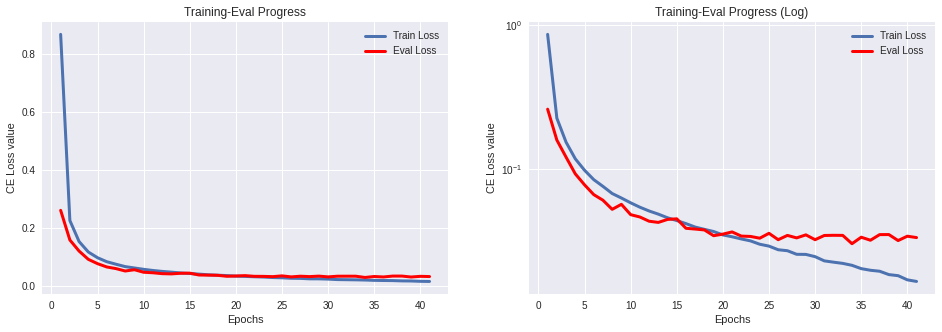

In [27]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

for a in ax:

    a.plot(epochs+1, train_loss, label="Train Loss", linewidth=3)
    a.plot(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", label="Eval Loss", linewidth=3)
#     a.scatter(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", s=100, marker="x")
    a.legend(loc="best")
    a.set_xlabel("Epochs")
    a.set_ylabel("CE Loss value")

ax[0].set_title("Training-Eval Progress")
ax[1].set_title("Training-Eval Progress (Log)")
ax[1].set_yscale("log")

plt.show()

In [28]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

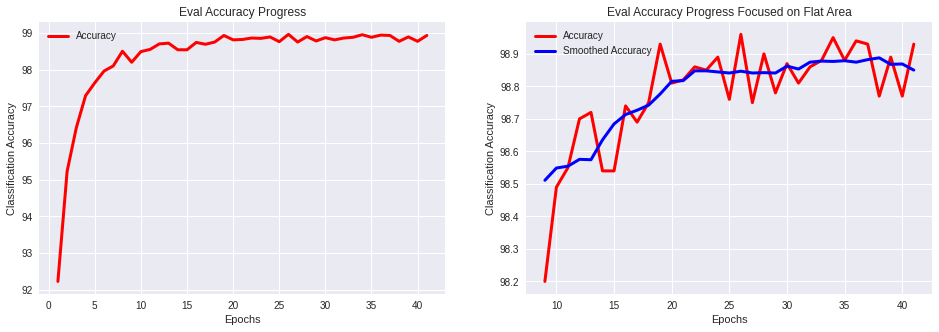

In [29]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax[0].plot(epochs[eval_idx]+1, accuracy[eval_idx], c="red", label="Accuracy", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Classification Accuracy")
ax[0].set_title("Eval Accuracy Progress")

IDX = 8
zoomed = accuracy[IDX:]
filtered = smooth(zoomed, K=9)

ax[1].plot(epochs[IDX:]+1, accuracy[IDX:], c="red", label="Accuracy", linewidth=3)
ax[1].plot(epochs[IDX:]+1, filtered, c="blue", label="Smoothed Accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Classification Accuracy")
ax[1].set_title("Eval Accuracy Progress Focused on Flat Area")

plt.show()

---

# Assignment 2
- Train and compare the MLP from Assignment 1 and a simple CNN on the CIFAR-10 dataset (available in PyTorch) with somewhat optimized hyper-parameters
- Visualize several convolutional kernels and activations from the first two convolutional layers
- Train CNNs without regularization, with L2-Regularization, and with L1-Regularization. Compare the results: training and validation loss, accuracy, ...
- Train model with and without data augmentation. Compare the results: training and validation loss, accuracy, ...
- **Extra Point**
   - Implement and use your own custom learning rate warmup and learning rate scheduler criterion to avoid overfitting

#### **Due Date**: Wednesady 30th November at 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment2 + Group Name**
####  Send me the following: Jupyter Notebook after running, Jupyter export as html, any other .py files or images used.

### **Next Session: Friday 2nd December**


# References
 - https://www.deeplearningbook.org/
 - http://cs231n.stanford.edu/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
 - https://github.com/vdumoulin/conv_arithmetic
 

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div> 